In [1]:
import torch
import numpy as np
import pandas as pd

In [4]:
#Testing out how torch work
arr = np.random.randn(3,5)
arr

array([[ 0.95032636,  0.61375371,  1.00964031,  1.70931826,  0.69478487],
       [ 0.4489823 ,  0.82865522, -0.18676852, -0.35651438, -0.68841716],
       [-1.23632274, -1.26323311, -1.01371577,  0.81779024,  0.77103902]])

In [5]:
#Making a tensor out of the array
tens = torch.from_numpy(arr)
tens

tensor([[ 0.9503,  0.6138,  1.0096,  1.7093,  0.6948],
        [ 0.4490,  0.8287, -0.1868, -0.3565, -0.6884],
        [-1.2363, -1.2632, -1.0137,  0.8178,  0.7710]], dtype=torch.float64)

In [6]:
#Making a random tensor
rand_tensor = torch.randn(4,3)
rand_tensor

tensor([[ 0.9869,  0.1692, -0.7316],
        [ 0.8770,  1.5257, -0.8486],
        [ 0.1923, -0.3235,  1.6946],
        [-1.8836, -0.3516, -1.1002]])

In [9]:
from torch.autograd import Variable


var_x = Variable(torch.randn(3,5))   #Creating a Variable
var_x

tensor([[ 0.0669,  2.1411, -0.1144, -0.0663, -0.9978],
        [-1.2608, -0.9515, -1.5467,  0.0272, -1.0112],
        [-1.0317,  0.3151, -0.1301,  1.5889,  0.1799]])

In [10]:
#We will now be trying examples of data loading and processing
from __future__ import print_function, division
import os
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   #Interactive mode

In [24]:
#Reading the data
landmark_frame = pd.read_csv('face_landmarks.csv')

In [25]:
landmark_frame.head(10)

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516
5,137341995_e7c48e9a75.jpg,-4,129,1,178,10,231,30,276,59,...,204,238,260,241,210,281,188,286,166,286
6,1383023626_8a49e4879a.jpg,0,48,-6,94,-10,141,-8,186,6,...,165,233,194,230,163,263,145,268,128,265
7,144044282_87cf3ff76e.jpg,122,104,121,116,121,129,122,142,125,...,165,154,178,154,164,153,159,154,154,153
8,152601997_ec6429a43c.jpg,109,66,108,98,111,132,118,169,127,...,205,216,239,220,208,216,197,217,187,216
9,1549040388_b99e9fa295.jpg,149,89,139,123,136,159,139,195,146,...,231,238,292,243,232,251,212,248,196,242


In [26]:
#The number of columns that we will be selecting is n
n = 65
img_name = landmark_frame.iloc[n,0]
landmarks = landmark_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


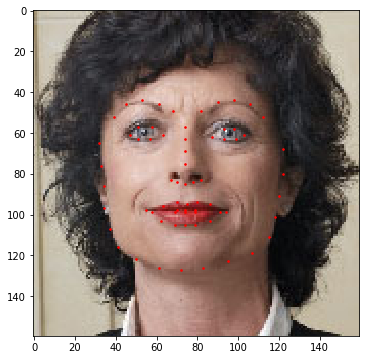

In [34]:
#Simple function to show an image and its associated landmarks
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure(figsize = (12,6))
show_landmarks(io.imread(img_name),
               landmarks)
plt.show()

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:
__len__ so that len(dataset) returns the size of the dataset.
__getitem__ to support the indexing such that dataset[i] can be used to get i th sample.
Let’s create a dataset class for our face landmarks dataset. We will read the csv in __init__ but leave the reading of images to __getitem__. This is memory efficient because all the images are not stored in the memory at once but read as required.
Sample of our dataset will be a dict {'image': image, 'landmarks': landmarks}. Our dataset will take an optional argument transform so that any required processing can be applied on the sample. We will see the usefulness of transform in the next section.

In [36]:

class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [44]:
face_dataset = FaceLandmarksDataset(csv_file= "C:/Users/Ganesh m/Desktop/Python/Python Learning/faces/face_landmarks.csv",
                                    root_dir= "C:/Users/Ganesh m/Desktop/Python/Python Learning/faces/")

0 (324, 215, 3) (68, 2)


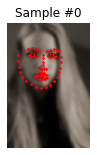

1 (500, 333, 3) (68, 2)


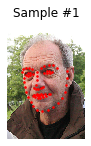

2 (250, 258, 3) (68, 2)


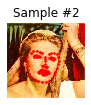

3 (434, 290, 3) (68, 2)


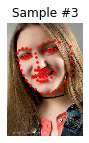

In [45]:
fig = plt.figure()


for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some prepocessing code. Let’s create three transforms:
Rescale: to scale the image
RandomCrop: to crop from image randomly. This is data augmentation.
ToTensor: to convert the numpy images to torch images (we need to swap axes).
We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it’s called. For this, we just need to implement __call__ method and if required, __init__ method. We can then use a transform like this:

In [46]:
#The class for rescaling an image to get the new height and weight of each image present in the dataset.
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

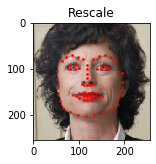

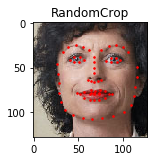

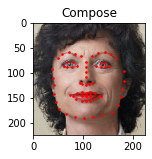

In [47]:
#Now we apply the rescale, crop and totensor classes.
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [51]:
transformed_dataset = FaceLandmarksDataset(csv_file="C:/Users/Ganesh m/Desktop/Python/Python Learning/faces/face_landmarks.csv",
                                           root_dir="C:/Users/Ganesh m/Desktop/Python/Python Learning/faces/",
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:
Batching the data
Shuffling the data
Load the data in parallel using multiprocessing workers.
torch.utils.data.DataLoader is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

In [52]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

BrokenPipeError: [Errno 32] Broken pipe